In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import randint
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


import warnings

warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv('drug200.csv')

In [3]:
dataframe.shape

(200, 6)

In [4]:
dataframe.sample(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
84,47,F,LOW,HIGH,10.067,drugC
13,74,F,LOW,HIGH,20.942,DrugY
40,73,F,NORMAL,HIGH,19.221,DrugY
137,35,F,HIGH,HIGH,12.894,drugA
143,74,M,HIGH,NORMAL,15.436,DrugY


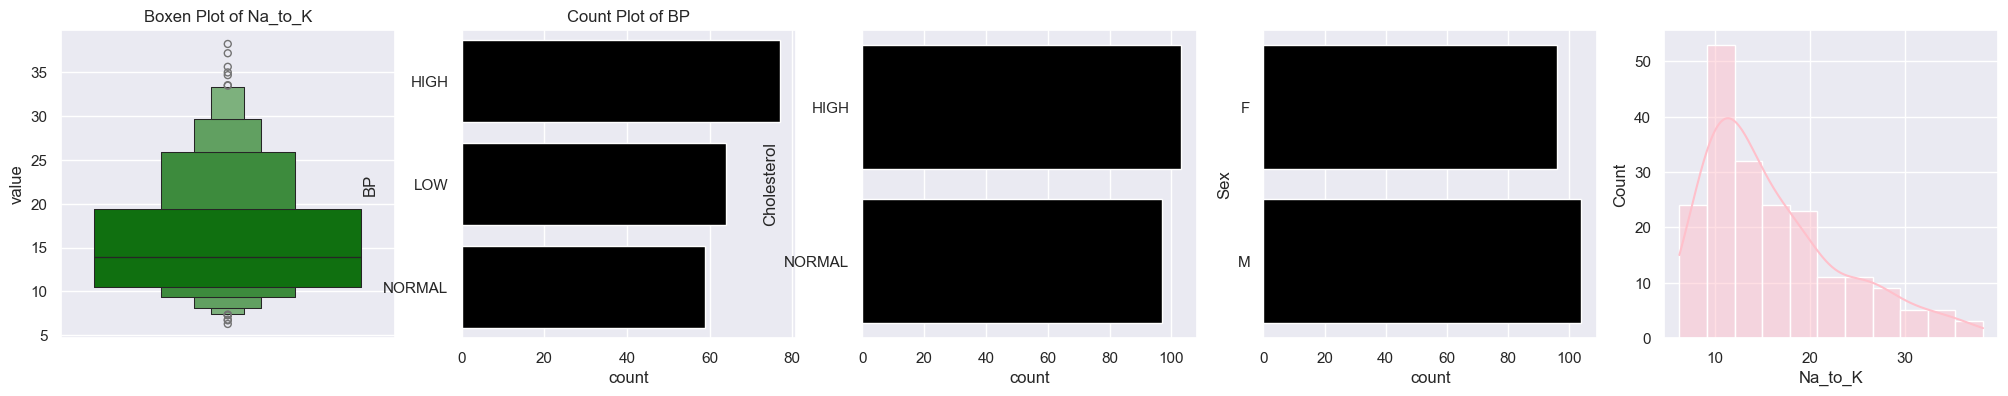

In [5]:
fig, ax = plt.subplots(1, 5, figsize=[25, 4])

# Boxen plot in the first subplot
sns.boxenplot(y='value', data=pd.melt(dataframe[['Na_to_K']]), color='green', ax=ax[0])
sns.countplot(dataframe.BP, ax=ax[1], color='black')
sns.countplot(dataframe.Cholesterol, ax=ax[2], color='black')
sns.countplot(dataframe.Sex, ax=ax[3], color='black')
sns.histplot(dataframe.Na_to_K, ax=ax[4], kde=True, color='pink')
ax[0].set_title('Boxen Plot of Na_to_K')
ax[1].set_title('Count Plot of BP')


plt.show()

## Data Wrangling

In [137]:
df = dataframe.copy()

In [39]:
def remove_outliers(input_df):
    Q1 = input_df['Na_to_K'].quantile(0.25)
    Q3 = input_df['Na_to_K'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    input_df[(input_df['Na_to_K'] >= lower_bound) & (input_df['Na_to_K'] <= upper_bound)]

    return input_df


def log1P(input_df):

    input_df['Na_to_K'] = np.log1p(input_df['Na_to_K'])

    return input_df

def age_to_cat(input_df):
    input_df['Age'] = input_df['Age'].apply(lambda x: 'Young Adult' if (15 <= x <= 35) else 'Adult' if (36 <= x <= 50) else 'Middle-Aged' if (51 <= x <= 65) else 'Senior' if (66 <= x <= 74) else 'Unknown')

    return input_df

class ImputeTransformer:

    def __init__(self, func) -> None:
        self.func = func

    def transform(self, input_df, **transform_params):

        return self.func(input_df)
    
    def fit(self, X, y=None, **fit_params):
        return self

In [40]:
df.sample(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
158,59,F,LOW,HIGH,10.444,drugC
12,43,M,LOW,HIGH,15.376,DrugY
8,60,M,NORMAL,HIGH,15.171,DrugY
133,24,M,NORMAL,HIGH,25.786,DrugY
110,50,M,HIGH,HIGH,7.490,drugA


In [51]:
df.sample(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
149,22,M,LOW,HIGH,8.151,3
116,67,M,NORMAL,NORMAL,9.514,4
68,54,M,NORMAL,HIGH,24.658,0
86,51,F,NORMAL,HIGH,13.597,4
195,56,F,LOW,HIGH,11.567,3


In [138]:
categorical_col = ['Age', 'Sex', 'BP', 'Cholesterol']
numeric_col = ['Na_to_K']

In [139]:
X,y = (df.drop(columns='Drug'), df.Drug)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
numeric_transformer = Pipeline(steps=[
    ('remove_outliers', ImputeTransformer(remove_outliers)),
    ('log1p', ImputeTransformer(log1P))
])

categoric_transformer = Pipeline(steps=[
    ('age_cat', ImputeTransformer(age_to_cat)),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])



col_transformer = ColumnTransformer([
    ('numerical_processing', numeric_transformer, numeric_col),
    ('categorical_processing', categoric_transformer, categorical_col)
], remainder='passthrough')

In [141]:
pipeline_lr = Pipeline([
    ('transform_column', col_transformer),
    ('logistic', LogisticRegression())
])

In [142]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_processing',
                                                  Pipeline(steps=[('remove_outliers',
                                                                   <__main__.ImputeTransformer object at 0x00000263FEBA41D0>),
                                                                  ('log1p',
                                                                   <__main__.ImputeTransformer object at 0x0000026386BAAF90>)]),
                                                  ['Na_to_K']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('age_cat',
                                                                   <__main__.ImputeTransformer object at 0x00000263872A51D0>),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Age', 'Sex', 'BP',
                                                   'Cholesterol'])])),
                ('logistic', LogisticRegression())])

In [143]:
cv_scores = cross_val_score(pipeline_lr, X, y, cv=5)

cv_scores.mean()

0.96

In [144]:
confusion_matrix(y_true=y_test, y_pred=pipeline_lr.predict(X_test))

array([[15,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0],
       [ 0,  0,  3,  0,  0],
       [ 0,  0,  0,  4,  1],
       [ 1,  0,  0,  0, 10]], dtype=int64)

In [145]:
gbc_pipeline = Pipeline([
    ('transform_column', col_transformer),
    ('gbc', GradientBoostingClassifier())
])

In [146]:
gbc_param_dist = {
    'gbc': [GradientBoostingClassifier()],
    'gbc__n_estimators': randint(50, 500),
    'gbc__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'gbc__max_depth': randint(3, 10),
    'gbc__min_samples_split': randint(2, 8),
    'gbc__min_samples_leaf': randint(1, 8)
}

In [147]:
rand_search = RandomizedSearchCV(estimator=gbc_pipeline, param_distributions=gbc_param_dist, cv=5, verbose=1, n_jobs=1)

In [148]:
gbc_model = rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [149]:
gbc_model.best_score_

0.99375

In [150]:
df.sample(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
20,57,M,LOW,NORMAL,19.128,DrugY
105,37,M,LOW,NORMAL,8.968,drugX
121,15,M,HIGH,NORMAL,17.206,DrugY


In [151]:
values = np.array([37, 'M', 'LOW', 'NORMAL', 8.968]).reshape(1, 5)

columns = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']

input_data = pd.DataFrame(values, columns=columns)
input_data['Age'] = input_data['Age'].astype('int64')
input_data['Na_to_K'] = input_data['Na_to_K'].astype('float64')

In [152]:
gbc_model.predict(input_data)

array(['drugX'], dtype=object)